In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
import pandas as pd
import seaborn as sns
from IPython.display import display
import pyspark.sql.functions as f
from pyspark.ml.feature import SQLTransformer, StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

In [4]:
spark_df = spark.read.options(delimiter = ',', inferSchema = 'True', header = 'True').csv('The_Cancer_data_1500_V2.csv')

In [5]:
train_df, test_df = spark_df.randomSplit(weights = [0.7,0.3], seed = 42)

In [6]:
print("Train")
display(train_df.select("Diagnosis").summary().toPandas())
print("Test")
display(test_df.select("Diagnosis").summary().toPandas())

Train


,summary,Diagnosis
0,count,1102
1,mean,0.37840290381125224
2,stddev,0.48520900962901126
3,min,0
4,25%,0
5,50%,0
6,75%,1
7,max,1


Test


,summary,Diagnosis
0,count,398
1,mean,0.35175879396984927
2,stddev,0.478120187782625
3,min,0
4,25%,0
5,50%,0
6,75%,1
7,max,1


In [7]:
sql_query = """
SELECT Age
, CASE WHEN Gender = 1 THEN 'Y' ELSE 'N' END AS Gender
, BMI
, CASE WHEN Smoking = 1 THEN 'Y' ELSE 'N' END AS Smoking
, CASE WHEN GeneticRisk = 0 THEN 'Low'
       WHEN GeneticRisk = 1 THEN 'Medium' 
       ELSE 'High' END AS GeneticRisk
, PhysicalActivity
, AlcoholIntake
, CASE WHEN CancerHistory = 1 THEN 'Y' ELSE 'N' END AS CancerHistory
, Diagnosis       
FROM __THIS__"""

sql_transformer = SQLTransformer(statement=sql_query)
sqltrans_df = sql_transformer.transform(train_df)
display(sqltrans_df.toPandas())

,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis
0,20,N,15.438809,N,Medium,3.831645,0.338982,N,0
1,20,N,16.985165,Y,Medium,9.068666,1.981237,Y,0
2,20,N,20.979503,Y,High,1.514104,4.927621,N,1
3,20,N,21.884529,N,Medium,4.346781,1.940665,N,0
4,20,N,22.438711,N,Low,9.678646,3.236111,Y,0
...,...,...,...,...,...,...,...,...,...
1097,80,Y,20.701994,N,Low,8.482031,3.152943,N,0
1098,80,Y,24.925376,Y,Low,7.996919,1.005683,N,0
1099,80,Y,27.308137,N,Low,5.797371,4.889967,Y,1
1100,80,Y,32.639647,N,Low,1.493994,2.975232,N,1


In [8]:
indexer = StringIndexer(inputCols = ['Gender', 'Smoking', 'GeneticRisk', 'CancerHistory'], 
                        outputCols = ['GenderIndexer', 'SmokingIndexer', 'GeneticRiskIndexer', 'CancerHistoryIndexer'])

indexer_df = indexer.fit(sqltrans_df).transform(sqltrans_df)
display(indexer_df.toPandas())

,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis,GenderIndexer,SmokingIndexer,GeneticRiskIndexer,CancerHistoryIndexer
0,20,N,15.438809,N,Medium,3.831645,0.338982,N,0,0.0,0.0,1.0,0.0
1,20,N,16.985165,Y,Medium,9.068666,1.981237,Y,0,0.0,1.0,1.0,1.0
2,20,N,20.979503,Y,High,1.514104,4.927621,N,1,0.0,1.0,2.0,0.0
3,20,N,21.884529,N,Medium,4.346781,1.940665,N,0,0.0,0.0,1.0,0.0
4,20,N,22.438711,N,Low,9.678646,3.236111,Y,0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,80,Y,20.701994,N,Low,8.482031,3.152943,N,0,1.0,0.0,0.0,0.0
1098,80,Y,24.925376,Y,Low,7.996919,1.005683,N,0,1.0,1.0,0.0,0.0
1099,80,Y,27.308137,N,Low,5.797371,4.889967,Y,1,1.0,0.0,0.0,1.0
1100,80,Y,32.639647,N,Low,1.493994,2.975232,N,1,1.0,0.0,0.0,0.0


In [9]:
from xgboost.spark import SparkXGBClassifier

feature_names = ['Age', 'GenderIndexer', 'BMI', 'SmokingIndexer', 'GeneticRiskIndexer',  
                 'PhysicalActivity', 'AlcoholIntake', 'CancerHistoryIndexer']

label_name = 'Diagnosis'

classifier = SparkXGBClassifier(
  features_col = feature_names,
  label_col = label_name,
  eval_metric = "auc",
  device = "gpu",
)

In [10]:
pipeline = Pipeline(stages=[sql_transformer, indexer, classifier])

In [11]:
model = pipeline.fit(train_df)

2024-06-29 21:20:34,815 WARNING SparkXGBClassifier: _validate_gpu_params You have enabled GPU in spark local mode. Please make sure your local node has at least 1 GPUs
2024-06-29 21:20:35,369 INFO XGBoost-PySpark: _fit Running xgboost-2.1.0 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'gpu', 'eval_metric': 'auc', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-06-29 21:20:36,976 INFO XGBoost-PySpark: _train_booster Leveraging cuda:0 to train with QDM: off
[21:20:38] Task 0 got rank 0
/home/NBuser/.local/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:20:38] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
2024-06-29 21:20:39,233 INFO XGBoost-PySpark: _fit Finished xgboost training!   


,Feature,Importance
5,PhysicalActivity,456.0
6,AlcoholIntake,422.0
2,BMI,398.0
0,Age,343.0
4,GeneticRiskIndexer,114.0
1,GenderIndexer,105.0
7,CancerHistoryIndexer,82.0
3,SmokingIndexer,80.0


<Axes: xlabel='Importance', ylabel='Feature'>

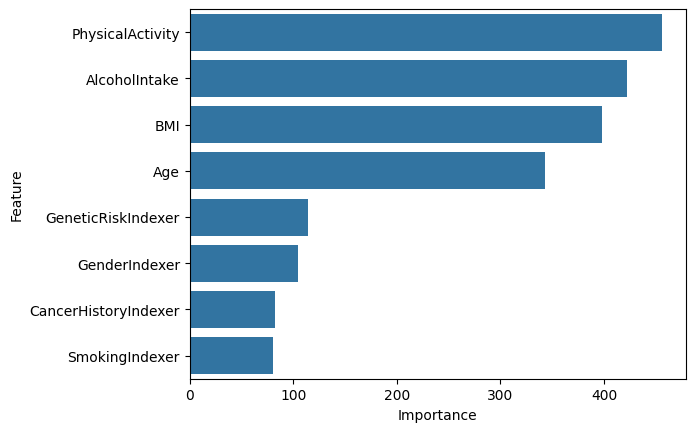

In [12]:
feature_importances = model.stages[2].get_feature_importances()

feat_imp = pd.DataFrame(zip(feature_importances.keys(), feature_importances.values()), columns = ['Feature', 'Importance'])
feat_imp = feat_imp.sort_values('Importance', ascending = False)

display(feat_imp)

sns.barplot(feat_imp, x="Importance", y="Feature", estimator="sum", errorbar=None, orient="y")

In [13]:
from pyspark.sql.types import ArrayType, FloatType

@f.udf(returnType=ArrayType(FloatType()))
def vector_to_array(v):
    # convert column of vectors into column of arrays
    a = v.values.tolist()
    return a

test_predict_df = model.transform(test_df).select('*',
                                          vector_to_array("probability")[0].alias('probability_0'),
                                          vector_to_array("probability")[1].alias('probability_1')).drop('rawPrediction', 'probability')

display(test_predict_df.toPandas())

2024-06-29 21:20:40,165 INFO XGBoost-PySpark: predict_udf CUDF or Cupy is unavailable, fallback the inference on the CPUs


,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Diagnosis,GenderIndexer,SmokingIndexer,GeneticRiskIndexer,CancerHistoryIndexer,prediction,probability_0,probability_1
0,20,N,17.545092,N,Low,1.684406,2.409186,N,0,0.0,0.0,0.0,0.0,0.0,0.999931,0.000069
1,20,N,22.489142,N,Medium,2.469654,2.968529,N,0,0.0,0.0,1.0,0.0,0.0,0.999938,0.000062
2,20,N,26.481630,N,Medium,8.985969,1.518619,N,0,0.0,0.0,1.0,0.0,0.0,0.999548,0.000452
3,20,N,26.495011,N,Medium,3.507098,2.236365,N,0,0.0,0.0,1.0,0.0,0.0,0.999279,0.000721
4,20,N,35.887006,N,Low,4.095609,4.040785,N,0,0.0,0.0,0.0,0.0,0.0,0.928683,0.071317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,80,N,32.592494,N,Low,8.715519,3.218853,N,1,0.0,0.0,0.0,0.0,0.0,0.979006,0.020994
394,80,N,38.897971,N,Low,6.491540,4.929292,Y,1,0.0,0.0,0.0,1.0,1.0,0.000420,0.999580
395,80,Y,23.702390,N,Low,2.672099,3.320629,N,0,1.0,0.0,0.0,0.0,0.0,0.971468,0.028532
396,80,Y,24.193984,N,Low,8.668215,3.326364,N,0,1.0,0.0,0.0,0.0,0.0,0.972368,0.027632


In [14]:
predictionAndTarget = test_predict_df.select(f.col('probability_1').cast('double'), f.col('Diagnosis').cast('double'))
evaluator = BinaryClassificationEvaluator(labelCol = 'Diagnosis', rawPredictionCol= 'probability_1', metricName = 'areaUnderROC')
auc = evaluator.evaluate(predictionAndTarget)
gini = 2 * auc - 1.0
print(f"Gini: {gini:.4f}")

2024-06-29 21:20:40,995 INFO XGBoost-PySpark: predict_udf CUDF or Cupy is unavailable, fallback the inference on the CPUs


Gini: 0.9003


2024-06-29 21:20:41,805 INFO XGBoost-PySpark: predict_udf CUDF or Cupy is unavailable, fallback the inference on the CPUs


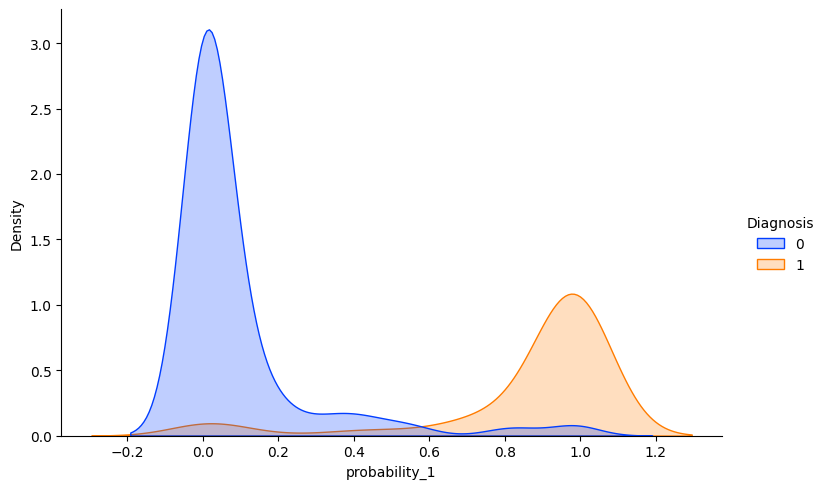

In [15]:
predict_proba = test_predict_df.select('Diagnosis','probability_0', 'probability_1').toPandas()
sns.displot(data=predict_proba, x = 'probability_1', hue = 'Diagnosis', kind = 'kde', fill = True, palette=sns.color_palette('bright')[:2], aspect=1.5)